# 

## Install Python libraries
* To temporarily install Python libraries for server use, use the command: `%pip`.

In [1]:
%pip install simplekml
%pip install geopy
%pip install -U kaleido

  Using cached simplekml-1.3.6-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.
  Using cached geopy-2.4.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached geographiclib-2.0-py3-none-any.whl.metadata (1.4 kB)
Using cached geopy-2.4.1-py3-none-any.whl (125 kB)
Using cached geographiclib-2.0-py3-none-any.whl (40 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached kaleido-0.2.1-py2.py3-none-manylinux1_x86_64.whl.metadata (15 kB)
Using cached kaleido-0.2.1-py2.py3-none-manylinux1_x86_64.whl (79.9 MB)
Note: you may need to restart the kernel to use updated packages.


# Python libraries

In [2]:
from sliderule import sliderule, icesat2, earthdata
import geopandas as gpd
import pandas as pd
import folium
import numpy as np
from shapely.geometry import Polygon, Point, mapping
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.linear_model import LinearRegression
import geopy
import simplekml
from geopy.distance import geodesic
from matplotlib.backends.backend_pdf import PdfPages
import plotly.express as px
from tqdm import tqdm
import warnings
from scipy.stats import linregress
import statsmodels.api as sm

In [3]:
segment_meter = "20"
cnt = "10"
ats = "10"

site_name = "BONA"
# site_name = "DEJU"
# site_name = "WREF"
# site_name = "RMNP"
# site_name = "TEAK"

boundary_km = "20"

year_folder = 'year/'
day_folder = 'day/'

In [4]:
def compile_dates_for_site(folder, site_name):
    """
    Reads all CSV files for the specified site in a folder, extracts the 'date' column,
    and compiles a unique list of dates.

    Args:
        folder (str): The directory containing the CSV files.

    Returns:
        list: A sorted list of unique dates for the specified site.
    """
    print(site_name)
    all_dates = set()  # Use a set to ensure unique dates

    # Iterate through all files in the folder
    for filename in os.listdir(folder):
        if filename.startswith(site_name) and filename.endswith(".csv"):  # Match site_name in the file name
            filepath = os.path.join(folder, filename)
            try:
                # Read the CSV file into a DataFrame
                df = pd.read_csv(filepath)
                if 'date' in df.columns and 'ground_photon_count' in df.columns and 'canopy_photon_count' in df.columns:
                    # Filter rows where both ground_photon_count and canopy_photon_count are 0
                    filtered_df = df[(df['ground_photon_count'] != 0) | (df['canopy_photon_count'] != 0)]
                    # Add unique dates directly from the 'date' column as strings
                    all_dates.update(filtered_df['date'].dropna().unique())
            except Exception as e:
                print(f"Error processing file {filename}: {e}")

    # Return sorted list of unique dates
    return sorted(all_dates)

site_dates = compile_dates_for_site(year_folder, site_name)
print(site_dates)

BONA
['2019-06-26', '2019-09-11', '2019-09-24', '2019-12-24', '2020-05-11', '2020-09-22', '2020-11-09', '2020-12-08', '2021-02-08', '2021-03-22', '2021-06-21', '2021-10-19', '2021-11-07', '2022-03-21', '2022-06-06', '2022-08-07', '2022-09-05', '2022-09-18', '2022-10-17', '2022-11-06', '2022-12-18', '2023-01-20', '2023-01-31', '2023-02-18', '2023-03-05', '2023-03-19', '2023-04-17', '2023-04-21', '2023-05-06', '2023-08-05', '2023-09-16', '2023-10-15', '2023-11-13']


In [5]:
def generate_date_time_ranges(dates):
    """
    Generate a dictionary of start and end times for each unique date.

    Args:
        dates (list of str): List of date strings in the format "YYYY-MM-DD".
        
    Returns:
        list of dict: A list of dictionaries where each dictionary represents a time range
                      with 'start_time' and 'end_time' for a specific date.
    """
    time_ranges = []
    for date in dates:
        start_time = f"{date}T00:00:00Z"
        end_time = f"{date}T23:59:59Z"
        
        # Append the date with its start_time and end_time to the time_ranges list
        time_ranges.append({
            "date": date, 
            "start_time": start_time, 
            "end_time": end_time
        })
    return time_ranges

site_time_ranges = generate_date_time_ranges(site_dates)
print(site_name)
for date in site_time_ranges:
    print(date)
print(len(site_time_ranges))

BONA
{'date': '2019-06-26', 'start_time': '2019-06-26T00:00:00Z', 'end_time': '2019-06-26T23:59:59Z'}
{'date': '2019-09-11', 'start_time': '2019-09-11T00:00:00Z', 'end_time': '2019-09-11T23:59:59Z'}
{'date': '2019-09-24', 'start_time': '2019-09-24T00:00:00Z', 'end_time': '2019-09-24T23:59:59Z'}
{'date': '2019-12-24', 'start_time': '2019-12-24T00:00:00Z', 'end_time': '2019-12-24T23:59:59Z'}
{'date': '2020-05-11', 'start_time': '2020-05-11T00:00:00Z', 'end_time': '2020-05-11T23:59:59Z'}
{'date': '2020-09-22', 'start_time': '2020-09-22T00:00:00Z', 'end_time': '2020-09-22T23:59:59Z'}
{'date': '2020-11-09', 'start_time': '2020-11-09T00:00:00Z', 'end_time': '2020-11-09T23:59:59Z'}
{'date': '2020-12-08', 'start_time': '2020-12-08T00:00:00Z', 'end_time': '2020-12-08T23:59:59Z'}
{'date': '2021-02-08', 'start_time': '2021-02-08T00:00:00Z', 'end_time': '2021-02-08T23:59:59Z'}
{'date': '2021-03-22', 'start_time': '2021-03-22T00:00:00Z', 'end_time': '2021-03-22T23:59:59Z'}
{'date': '2021-06-21', 's

In [6]:
%%time

def process_site(site, time_ranges, boundary_km):
    """
    Processes a site by requesting ATL03 data for specified time ranges.

    Args:
        region (dict): A dictionary containing the spatial region of interest, with a 'poly' key for the polygon.
        time_ranges (dict): A dictionary where keys are years, and values are dictionaries with 'start_time' and 'end_time'.
        cnt (int, optional): Number of photons required for the analysis. Defaults to None.
        ats (int, optional): Along-track spacing for the data. Defaults to None.
        segment_meter (float, optional): Segment length and resolution in meters. Defaults to 10.

    Returns:
        dict: A dictionary where keys are years, and values are the retrieved ATL03 data.
    """
    # Load the region dynamically based on the site
    region = sliderule.toregion(f"geojson_files/{site}_buffer_{boundary_km}km.geojson")
    
    # Dictionary to store ATL03 data for each year
    site_data = {}
    
    for time_range  in time_ranges:
        # Construct the parameters for the current time range
        parms = {
            "poly": region['poly'],       # Region polygon
            "t0": time_range['start_time'],   # Start time
            "t1": time_range['end_time'],     # End time
            "srt": icesat2.SRT_LAND,           # Surface return type
            "cnf": 0,                    # Confidence level (2 is low-confidence)
            "cnt": cnt,                  # Number of photons
            "ats": ats,                  # Along-track spacing
            "len": segment_meter,        # Segment length
            "res": segment_meter,        # Resolution
            "atl08_class": [             # ATL08 classifications
                "atl08_noise",
                "atl08_ground",
                "atl08_canopy",
                "atl08_top_of_canopy",
                "atl08_unclassified"
            ],
            "phoreal": {                 # Phoreal processing settings
                "binsize": 1.0,
                "geoloc": "mean",
                "use_abs_h": True,
                "send_waveform": True
            }
        }

        # Request the ATL03 data using icesat2
        atl03_data = icesat2.atl03sp(parms, keep_id=True)
        
       # If only the 'geometry' column remains, skip this date
        if atl03_data.shape[1] == 1 and 'geometry' in atl03_data.columns:
            print(f"Skipping {time_range['date']} because it only contains geometry data.")
            continue
            
        columns_to_drop = [
        'region', 'pair', 'segment_dist', 'segment_id', 'cycle', 'track', 'background_rate', 'y_atc', 'x_atc', 
            'yapc_score', 'atl03_cnf', 'relief', 'quality_ph'
        ]
        
        # Drop the columns from the DataFrame
        atl03_data = atl03_data.drop(columns=columns_to_drop)
        
        # Use the date as the key for storing data
        site_data[time_range['date']] = atl03_data

    return site_data

site_data = process_site(site_name, site_time_ranges, boundary_km)

CPU times: user 7min 35s, sys: 11.8 s, total: 7min 47s
Wall time: 9min 38s


In [7]:
# Loop through the site_data dictionary

print (len(site_data))
for date, site_datum in site_data.items():
    print(f"Date: {date}")
    print("Columns:", site_datum.columns.tolist())  # Print the list of column names

33
Date: 2019-06-26
Columns: ['solar_elevation', 'rgt', 'extent_id', 'sc_orient', 'landcover', 'atl08_class', 'height', 'snowcover', 'geometry', 'spot']
Date: 2019-09-11
Columns: ['solar_elevation', 'rgt', 'extent_id', 'sc_orient', 'landcover', 'atl08_class', 'height', 'snowcover', 'geometry', 'spot']
Date: 2019-09-24
Columns: ['solar_elevation', 'rgt', 'extent_id', 'sc_orient', 'landcover', 'atl08_class', 'height', 'snowcover', 'geometry', 'spot']
Date: 2019-12-24
Columns: ['solar_elevation', 'rgt', 'extent_id', 'sc_orient', 'landcover', 'atl08_class', 'height', 'snowcover', 'geometry', 'spot']
Date: 2020-05-11
Columns: ['solar_elevation', 'rgt', 'extent_id', 'sc_orient', 'landcover', 'atl08_class', 'height', 'snowcover', 'geometry', 'spot']
Date: 2020-09-22
Columns: ['solar_elevation', 'rgt', 'extent_id', 'sc_orient', 'landcover', 'atl08_class', 'height', 'snowcover', 'geometry', 'spot']
Date: 2020-11-09
Columns: ['solar_elevation', 'rgt', 'extent_id', 'sc_orient', 'landcover', 'atl0

In [8]:
%%time
def process_photons(site_data):
    """
    Processes site data to calculate canopy and terrain photon rates for each segment and checks for duplicate times.

    Args:
        site_data (dict): A dictionary where each value is a DataFrame containing data for a site.

    Returns:
        dict: A dictionary with the same keys as `site_data`, containing processed DataFrames.
    """
    processed_data = {}

    for date, data in site_data.items():
        # Ensure 'time' is the index and in datetime format
        data.index = pd.to_datetime(data.index)

        # Extract latitude and longitude from the 'geometry' column
        data['latitude'] = data['geometry'].apply(lambda x: x.y if x else None)
        data['longitude'] = data['geometry'].apply(lambda x: x.x if x else None)

        # Separate photons into canopy and terrain classes
        canopy_photons = data[data['atl08_class'].isin([2, 3])]  # Classes 2 and 3 for canopy
        terrain_photons = data[data['atl08_class'] == 1]         # Class 1 for ground

        # Count photons for each segment
        canopy_counts = canopy_photons.groupby('extent_id').size().reset_index(name='canopy_photon_count')
        terrain_counts = terrain_photons.groupby('extent_id').size().reset_index(name='terrain_photon_count')

        # Convert the index to a column temporarily
        data['time_index'] = data.index
        
        # Group by 'extent_id' and count unique 'time_index' values (representing unique times)
        unique_time_count = (
            data.groupby('extent_id')['time_index']
            .nunique()
            .reset_index(name='unique_shots')
        )
        
        # Drop the temporary 'time_index' column
        data = data.drop(columns='time_index')

        # Merge canopy and terrain counts into one DataFrame
        segment_counts = (
            canopy_counts
            .merge(terrain_counts, on='extent_id', how='outer')
            .merge(unique_time_count, on='extent_id', how='outer')
        )

        # Replace any zero or NaN values in 'unique_shots' with NaN to avoid division by zero errors
        segment_counts['unique_shots'] = segment_counts['unique_shots'].replace(0, np.nan)

        # Calculate photon rates by normalizing with the number of unique shots
        segment_counts['canopy_photon_rate'] = segment_counts['canopy_photon_count'] / segment_counts['unique_shots']
        segment_counts['terrain_photon_rate'] = segment_counts['terrain_photon_count'] / segment_counts['unique_shots']

        # Reset index to keep 'time' as a column for merging
        data = data.reset_index()

        # Merge photon rates into the main DataFrame
        data = data.merge(
            segment_counts[['extent_id', 'canopy_photon_rate', 'terrain_photon_rate']], 
            on='extent_id', how='left'
        )

        # Check for duplicates in the 'time' column
        duplicate_times = data[data.index.duplicated()]

        # Log duplicates if needed (optional)
        if not duplicate_times.empty:
            print(f"date {date}: Found duplicate times in the 'time' column.")

        # Store processed data
        processed_data[date] = data

    return processed_data

processed_site_data = process_photons(site_data)

CPU times: user 9min 30s, sys: 11.3 s, total: 9min 41s
Wall time: 9min 27s


In [9]:
%time
def output_photon_counts_by_day(processed_site_data, output_dir, boundary_km):
    """
    Outputs photon counts by day for each site, separated by ATL08 categories, into CSV files.

    Args:
        processed_site_data (dict): A dictionary where each value is a DataFrame containing processed data for a site.
        output_dir (str): The directory where the CSV files should be saved.
        site_name (str): The name of the site (used for output file naming).
        ats (str): The ATS value (used for output file naming).

    Returns:
        None
    """
    # Define ATL08 classification categories and their values
    atl08_categories = {
        "unclassified": 0,
        "ground": 1,
        "canopy": 2,
        "top_of_canopy": 3,
        "noise": 4
    }
        
    # Dictionary to track open file handles for each year
    file_handles = {}
    
    try:
        for date_str, data in processed_site_data.items():
            # Parse the year from the date string
            year = pd.to_datetime(date_str).year

            # Ensure 'date' column is included
            data['date'] = pd.to_datetime(date_str).strftime('%Y-%m-%d')

            # Count photons for each ATL08 category
            category_counts = {}
            for category, value in atl08_categories.items():
                category_counts[category] = (data[data['atl08_class'] == value].groupby('date').size().reset_index(name=f"{category}_photon_count"))

            # Count unique segments (extent_id) for each date
            segment_counts_by_date = (data.groupby('date')['extent_id'].nunique().reset_index(name="segment_count"))
    
            # Start with the segment counts
            counts_by_date = segment_counts_by_date
    
            # Merge counts for each ATL08 category
            for category, count_df in category_counts.items():
                counts_by_date = counts_by_date.merge(count_df, on="date", how="outer")
    
            # Fill NaN values with 0 for days where no photons are present in a category
            counts_by_date.fillna(0, inplace=True)
            
            savepath = os.path.join(output_dir, site_name)
            # Ensure the output directory exists
            if not os.path.exists(savepath):
                os.makedirs(savepath)
                
            # If the file for this year hasn't been initialized, create it with headers
            if year not in file_handles:
                savefile = os.path.join(output_dir, site_name, f'{site_name}_photons_{year}_ats{ats}_{boundary_km}km.csv')
                file_handles[year] = savefile
                counts_by_date.to_csv(savefile, index=False)
            else:
                # Append to the existing file for the year
                counts_by_date.to_csv(file_handles[year], index=False, mode='a', header=False)

    finally:
        # Close file handles if necessary (pandas handles this implicitly, but good practice)
        file_handles.clear()

output_photon_counts_by_day(processed_site_data, day_folder, boundary_km)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [10]:
# # Adjust display options
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.width', None)        # Use full width of the terminal
# pd.set_option('display.expand_frame_repr', False)  # Avoid column wrapping

# # Group by 'extent_id' and 'spot', then get the first row for each unique combination
# unique_spot_rows = processed_site_data["2023-04-21"].drop_duplicates(subset=['extent_id', 'spot'])

# # Display the result
# print(len(unique_spot_rows))
# # unique_spot_rows.head(50)
# print(unique_spot_rows.head())
# del unique_spot_rows

In [11]:
%%time
def add_landcover_and_date_info(processed_site_data):
    """
    Adds landcover mode and date-related columns (month, year, day) to each site DataFrame in processed_site_data.

    Args:
        processed_site_data (dict): A dictionary where each value is a DataFrame containing data for a site.

    Returns:
        dict: A dictionary with the same keys as `processed_site_data`, containing updated DataFrames.
    """
    valid_landcover_codes = {111, 113, 112, 114, 115, 116, 121, 123, 122, 124, 125, 126, 20}

    updated_data = {}

    for date, data in processed_site_data.items():
        # Step 1: Ensure there are no invalid landcover values before grouping
        valid_landcover_data = data[data["landcover"].isin(valid_landcover_codes)].copy()

        # Step 2: Calculate the landcover mode for each extent_id
        landcover_modes = valid_landcover_data.groupby("extent_id")["landcover"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

        # Step 3: Assign the calculated mode back to the original DataFrame
        data["landcover_mode"] = data["extent_id"].map(landcover_modes)

        # Step 4: Set 'time' back as the index if not already
        if "time" in data.columns:
            data.set_index("time", inplace=True)
            data.index = pd.to_datetime(data.index)

        # Step 5: Extract month, year, and day for aggregation
        data["month"] = data.index.month
        data["year"] = data.index.year
        data["day"] = data.index.day

        # Store the updated DataFrame in the dictionary
        updated_data[date] = data

    return updated_data

processed_site_data = add_landcover_and_date_info(processed_site_data)

CPU times: user 27.9 s, sys: 242 ms, total: 28.1 s
Wall time: 28.1 s


In [12]:
# # Adjust display options
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.width', None)        # Use full width of the terminal
# pd.set_option('display.expand_frame_repr', False)  # Avoid column wrapping

# # Group by 'extent_id' and 'spot', then get the first row for each unique combination
# unique_spot_rows = processed_site_data["2019-09-11"].drop_duplicates(subset=['extent_id', 'spot'])

# # Display the result
# print(len(unique_spot_rows))
# # unique_spot_rows.head(50)
# print(unique_spot_rows.head(50))
# del unique_spot_rows

In [13]:
def count_solar_elevation_values(processed_site_data):
    """
    Counts how many entries have positive or 0 values and how many have negative values in the solar_elevation column.

    Args:
        processed_site_data (dict): A dictionary where each value is a DataFrame containing processed site data.

    Returns:
        dict: A dictionary with the same keys as `processed_site_data`, containing the counts for positive/zero and negative values.
    """
    elevation_counts = {}

    for date, data in processed_site_data.items():
        # Ensure the 'solar_elevation' column exists
        if 'solar_elevation' in data.columns:
            # Count positive or 0 values
            positive_or_zero_count = (data['solar_elevation'] >= 0).sum()

            # Count negative values
            negative_count = (data['solar_elevation'] < 0).sum()

            # Store counts in the dictionary
            elevation_counts[date] = {
                "daytime": positive_or_zero_count,
                "nighttime": negative_count
            }
        else:
            print(f"Warning: 'solar_elevation' column not found for {date}. Skipping.")
            elevation_counts[date] = {"positive_or_zero": 0, "negative": 0}

    return elevation_counts

# Example usage:
solar_elev_counts = count_solar_elevation_values(processed_site_data)

for date, counts in solar_elev_counts.items():
    print(f"date: {date}, Daytime_photon_count: {counts['daytime']}, Nighttime_photon_count: {counts['nighttime']}")

date: 2019-06-26, Daytime_photon_count: 998804, Nighttime_photon_count: 0
date: 2019-09-11, Daytime_photon_count: 0, Nighttime_photon_count: 49406
date: 2019-09-24, Daytime_photon_count: 840861, Nighttime_photon_count: 0
date: 2019-12-24, Daytime_photon_count: 0, Nighttime_photon_count: 651835
date: 2020-05-11, Daytime_photon_count: 2049615, Nighttime_photon_count: 0
date: 2020-09-22, Daytime_photon_count: 0, Nighttime_photon_count: 160225
date: 2020-11-09, Daytime_photon_count: 0, Nighttime_photon_count: 194
date: 2020-12-08, Daytime_photon_count: 0, Nighttime_photon_count: 163728
date: 2021-02-08, Daytime_photon_count: 0, Nighttime_photon_count: 786618
date: 2021-03-22, Daytime_photon_count: 2125739, Nighttime_photon_count: 0
date: 2021-06-21, Daytime_photon_count: 578094, Nighttime_photon_count: 0
date: 2021-10-19, Daytime_photon_count: 0, Nighttime_photon_count: 603247
date: 2021-11-07, Daytime_photon_count: 340059, Nighttime_photon_count: 0
date: 2022-03-21, Daytime_photon_count: 

KeyError: 'other'

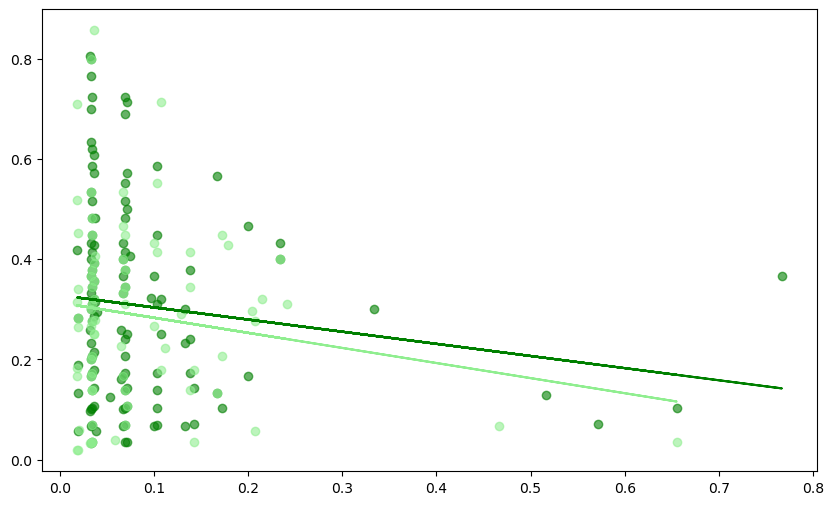

In [25]:
%%time
def plot_all_sites_photon_by_landcover(processed_site_data, folder, site_name, solar_elev_counts, boundary_km, sigma=0.1):
    # Define landcover categories and descriptions
    landcover_categories = {
        'cf_evgr': [111],
        'cf_mix_unknw': [115, 116],
        # 'open_forest': [121, 123, 122, 124, 125, 126],
        # 'shrubs': [20],
        # 'other': [key for key in range(1, 1000) if key not in [111, 113, 112, 114, 115, 116, 121, 123, 122, 124, 125, 126, 20]]
    }

    landcover_descriptions = {
        111: 'Closed forest, evergreen needle leaf',
        113: 'Closed forest, deciduous needle leaf',
        112: 'Closed forest, evergreen broad leaf',
        114: 'Closed forest, deciduous broad leaf',
        115: 'Closed forest, mixed',
        116: 'Closed forest, unknown',
        121: 'Open forest, evergreen needle leaf',
        123: 'Open forest, deciduous needle leaf',
        122: 'Open forest, evergreen broad leaf',
        124: 'Open forest, deciduous broad leaf',
        125: 'Open forest, mixed',
        126: 'Open forest, unknown',
        20: 'Shrubs'
    }

    regression_results = {'strong': {}, 'weak': {}}  
    landcover_colors = {
        'cf_evgr': 'green',
        'cf_mix_unknw': 'lightgreen',
        # 'open_forest': 'orange',
        # 'shrubs': 'blue',
        # 'other': 'gray'
    }

    for date, data in processed_site_data.items():
        daytime_count = solar_elev_counts.get(date, {}).get("daytime", 0)
        nighttime_count = solar_elev_counts.get(date, {}).get("nighttime", 0)
        time_of_day = "Daytime" if daytime_count > nighttime_count else "Nighttime"

        for beam_type, beams in {'strong': [1, 3, 5], 'weak': [2, 4, 6]}.items():
            target_date = pd.to_datetime(date).date()
            data['constructed_date'] = pd.to_datetime(data[['year', 'month', 'day']])
            beam_filter = data['spot'].isin(beams)
            filtered_data = data[(data['constructed_date'].dt.date == target_date) & beam_filter]
            filtered_data = filtered_data.dropna(subset=['canopy_photon_rate', 'terrain_photon_rate', 'landcover'])
            filtered_data = filtered_data.drop_duplicates(subset=['canopy_photon_rate', 'terrain_photon_rate', 'landcover'])

            # Function to get the broader landcover category
            def get_landcover_category(landcover_code, landcover_categories):
                for category, codes in landcover_categories.items():
                    if landcover_code in codes:
                        return category

            filtered_data['landcover_category'] = filtered_data['landcover'].apply(lambda x: get_landcover_category(x, landcover_categories))

            if filtered_data.empty:
                print(f"No data available for {target_date} with {beam_type} beams.")
                continue

            fig, ax = plt.subplots(figsize=(10, 6))
            landcover_regression_results = {}

            for landcover_category, group_data in filtered_data.groupby('landcover_category'):
                if len(group_data) >= 10:
                    # Calculate the standard deviation of terrain photon rate for weighting
                    std_terrain = group_data['terrain_photon_rate'].std()
                    if std_terrain == 0:  # Avoid division by zero
                        weights = np.ones(len(group_data))  # Default weight
                    else:
                        weights = np.exp(- (std_terrain ** 2) / (sigma ** 2))  # Apply exponential decay
                        weights = np.full(len(group_data), weights)  # Apply the same weight for all data points

                    # Perform weighted linear regression using your `weighted_regression` function
                    slope, intercept = weighted_regression(group_data['terrain_photon_rate'], group_data['canopy_photon_rate'], weights)

                    regression_line = slope * group_data['terrain_photon_rate'] + intercept
                    rv_rg = -1 * slope

                    ax.scatter(
                        group_data['terrain_photon_rate'], 
                        group_data['canopy_photon_rate'], 
                        color=landcover_colors[landcover_category], 
                        label=f"{landcover_category} Rv/Rg: {rv_rg:.2f}", 
                        alpha=0.6
                    )
                    ax.plot(
                        group_data['terrain_photon_rate'], 
                        regression_line, 
                        linestyle='-', 
                        label=f"{landcover_category} Rv/Rg: {rv_rg:.2f}",
                        color=landcover_colors[landcover_category]
                    )

                    landcover_regression_results[landcover_category] = {
                        'rv_rg': rv_rg, 
                        'slope': slope, 
                        'intercept': intercept
                    }

            if not landcover_regression_results:
                print(f"No valid data for {date} with {beam_type} beams. Skipping plot.")
                plt.close()
                continue

            combined_slope, combined_intercept, *_ = linregress(filtered_data['terrain_photon_rate'], filtered_data['canopy_photon_rate'])
            combined_rv_rg = -1 * combined_slope
            combined_line = combined_slope * filtered_data['terrain_photon_rate'] + combined_intercept
            ax.plot(
                filtered_data['terrain_photon_rate'], 
                combined_line, 
                color='red', 
                linestyle='--', 
                label=f"Combined Rv/Rg: {combined_rv_rg:.2f}"
            )

            regression_results[beam_type].setdefault(date, {})['combined'] = {
                'rv_rg': combined_rv_rg, 
                'slope': combined_slope, 
                'intercept': combined_intercept
            }
            regression_results[beam_type][date].update(landcover_regression_results)

            ax.set_xlabel('Terrain Photon Rate', fontsize=25)
            ax.set_ylabel('Canopy Photon Rate', fontsize=25)
            ax.set_title(f'{beam_type.capitalize()} Beams - {target_date} ({time_of_day}) {boundary_km}km', fontsize=30)
            ax.legend(fontsize=15)
            ax.grid(True)

            save_folder = os.path.join(folder, site_name, boundary_km)
            os.makedirs(save_folder, exist_ok=True)
            savefile = os.path.join(save_folder, f'{site_name}_{date}_{beam_type}_{boundary_km}km_landcover.png')
            # plt.savefig(savefile, bbox_inches='tight', dpi=300)
                
            plt.show()
            print(f"Plot saved as {savefile}")

            plt.close()

    return regression_results

regression_results2 = plot_all_sites_photon_by_landcover(processed_site_data, day_folder, site_name, solar_elev_counts, boundary_km)

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_regression_time_series(regression_results, site_name, folder, boundary_km):
    """
    Plots time series of regression results for:
    1. Combined landcover categories (cf_evgr, cf_mix_unknw) for all beams
    2. Strong and weak beams for combined landcover categories
    3. Specific landcover categories (cf_evgr, cf_mix_unknw) for strong and weak beams
    
    Args:
        regression_results (dict): Regression results for strong and weak beams.
        site_name (str): The name of the site for naming the plot.
        folder (str): The folder where the plots should be saved.
        boundary_km (int): The boundary distance (in kilometers) to include in the plot name.
    """
    # Helper function to extract rv_rg time series
    def extract_time_series_for_rv_rg(regression_results):
        time_series_data = {
            'cf_evgr': [],
            'cf_mix_unknw': [],
            'strong_combined': [],
            'strong_cf_evgr': [],
            'strong_cf_mix_unknw': [],
            'weak_combined': [],
            'weak_cf_evgr': [],
            'weak_cf_mix_unknw': []
        }

        # Loop through the 'strong' and 'weak' categories
        for beam_type, date_results in regression_results.items():
            for date, results in date_results.items():
                date_obj = pd.to_datetime(date)
                
                # Extract the rv_rg for each landcover category (combined, cf_evgr, cf_mix_unknw)
                if 'cf_evgr' in results:
                    time_series_data['cf_evgr'].append({'date': date_obj, 'rv_rg': results['cf_evgr']['rv_rg']})
                if 'cf_mix_unknw' in results:
                    time_series_data['cf_mix_unknw'].append({'date': date_obj, 'rv_rg': results['cf_mix_unknw']['rv_rg']})
                
                # Strong and weak beams: combined and specific landcovers
                if 'combined' in results:
                    time_series_data[f'{beam_type}_combined'].append({'date': date_obj, 'rv_rg': results['combined']['rv_rg']})
                if 'cf_evgr' in results:
                    time_series_data[f'{beam_type}_cf_evgr'].append({'date': date_obj, 'rv_rg': results['cf_evgr']['rv_rg']})
                if 'cf_mix_unknw' in results:
                    time_series_data[f'{beam_type}_cf_mix_unknw'].append({'date': date_obj, 'rv_rg': results['cf_mix_unknw']['rv_rg']})
        
        return time_series_data

    # Function to plot time series
    def plot_time_series(data, x_col, y_col, hue_col, title, y_label, save_name, color_map=None):
        fig, ax = plt.subplots(figsize=(12, 6))
        for key, group in data.groupby(hue_col):
            color = color_map.get(key, None) if color_map else None
            ax.plot(group[x_col], group[y_col], label=key, color=color, marker='o', linestyle='-')
        
        # Title and labels
        ax.set_title(title, fontsize=25)
        ax.set_xlabel('Date', fontsize=25)
        ax.set_ylabel(y_label, fontsize=25)
        ax.tick_params(axis='x', rotation=45, labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        
        # Add legend
        ax.legend(title=hue_col.capitalize(), fontsize=15)
        
        # Add grid
        ax.grid(True, which='both', linestyle='--', alpha=0.6)
        
        # Save the plot
        savefolder = os.path.join(folder, site_name, str(boundary_km) + 'km')

        # Create the directory structure if it doesn't exist
        if not os.path.exists(savefolder):
            os.makedirs(savefolder)
            print(f"Created directory: {savefolder}")
        
        savefile = os.path.join(savefolder, f"{site_name}_{save_name}_{boundary_km}km.png")
        plt.tight_layout()
        # plt.savefig(savefile, dpi=300)
        plt.show()
        print(f"Plot saved: {savefile}")

    # Extract time series for rv_rg values
    time_series_data = extract_time_series_for_rv_rg(regression_results)

    # Plot 1: cf_evgr and cf_mix_unknw for all beams (combined)
    if time_series_data['cf_evgr'] or time_series_data['cf_mix_unknw']:
        cf_evgr_mix_df = pd.concat([
            pd.DataFrame(time_series_data['cf_evgr']).assign(landcover='cf_evgr'),
            pd.DataFrame(time_series_data['cf_mix_unknw']).assign(landcover='cf_mix_unknw')
        ])
        plot_time_series(data=cf_evgr_mix_df, x_col='date', y_col='rv_rg', hue_col='landcover',
                         title=f"cf_evgr and cf_mix_unknw Rv/Rg Time Series at {site_name} {boundary_km}km",
                         y_label='Rv/Rg', save_name='cf_evgr_mix_time_series')

    # Plot 2: Strong and weak combined regressions
    if time_series_data['strong_combined'] or time_series_data['weak_combined']:
        combined_df = pd.concat([
            pd.DataFrame(time_series_data['strong_combined']).assign(beam_type='Strong Combined'),
            pd.DataFrame(time_series_data['weak_combined']).assign(beam_type='Weak Combined')
        ])
        plot_time_series(data=combined_df, x_col='date', y_col='rv_rg', hue_col='beam_type',
                         title=f"Combined Rv/Rg Time Series for Strong and Weak Beams at {site_name} {boundary_km}km",
                         y_label='Rv/Rg', save_name='combined_beams_time_series')

    # Plot 3: Strong and weak cf_evgr
    if time_series_data['strong_cf_evgr'] or time_series_data['weak_cf_evgr']:
        cf_evgr_df = pd.concat([
            pd.DataFrame(time_series_data['strong_cf_evgr']).assign(beam_type='Strong cf_evgr'),
            pd.DataFrame(time_series_data['weak_cf_evgr']).assign(beam_type='Weak cf_evgr')
        ])
        plot_time_series(data=cf_evgr_df, x_col='date', y_col='rv_rg', hue_col='beam_type',
                         title=f"cf_evgr Rv/Rg Time Series for Strong and Weak Beams at {site_name} {boundary_km}km",
                         y_label='Rv/Rg', save_name='cf_evgr_beams_time_series')

    # Plot 4: Strong and weak cf_mix_unknw
    if time_series_data['strong_cf_mix_unknw'] or time_series_data['weak_cf_mix_unknw']:
        cf_mix_unknw_df = pd.concat([
            pd.DataFrame(time_series_data['strong_cf_mix_unknw']).assign(beam_type='Strong cf_mix_unknw'),
            pd.DataFrame(time_series_data['weak_cf_mix_unknw']).assign(beam_type='Weak cf_mix_unknw')
        ])
        plot_time_series(data=cf_mix_unknw_df, x_col='date', y_col='rv_rg', hue_col='beam_type',
                         title=f"cf_mix_unknw Rv/Rg Time Series for Strong and Weak Beams at {site_name} {boundary_km}km",
                         y_label='Rv/Rg', save_name='cf_mix_unknw_beams_time_series')


plot_regression_time_series_landcover(regression_results2, site_name, day_folder, boundary_km)